In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tempfile
import os

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, cross_validate, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import pymc as pm
import arviz as az
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import scikit_posthocs as sp
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import baycomp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Lectura y Preparación de los Modelos

In [3]:
df = pd.read_csv('train_cleaned.csv')

In [4]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns=['Transported'])
y = df['Transported']

In [5]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### El Mejor Modelo?

In [ ]:
# Definir los clasificadores individuales
gb = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, max_depth=4, subsample=0.75, random_state=42)
xgb = XGBClassifier(n_estimators=1500, learning_rate=0.01, max_depth=4, subsample=0.75, random_state=1)
svc = SVC(probability=True, kernel='rbf', C=1, gamma=0.1, random_state=42)
voting_clf_svc = VotingClassifier(estimators=[('gb', gb), ('svc', svc), ('xgb', xgb)], voting='soft')
ada = AdaBoostClassifier(n_estimators=600, learning_rate=0.01, algorithm='SAMME', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
voting_good = VotingClassifier(estimators=[('xgb', xgb), ('ada', ada), ('knn', knn)], voting='soft')
cat_boost = CatBoostClassifier(depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1, random_state=42)
voting_cat = VotingClassifier(estimators=[('cat', cat_boost), ('ada', ada), ('knn', knn)], voting='soft')


# Diccionario final con todos los clasificadores
classifiers = {
    'XGBoost': xgb,
    'CatBoost': cat_boost,
    'VotingClassifier con SVC': voting_clf_svc,
    'VotingClassifier Ajustado': voting_good,
    'Voting Classifier con CatBoost': voting_cat
}

# Definir las métricas para la validación cruzada
scoring = {
    'Accuracy': 'accuracy',
    'Precision': 'precision_weighted',
    'Recall': 'recall_weighted',
    'F1': 'f1_weighted',
    'ROC AUC': 'roc_auc'
}

# Evaluar los clasificadores utilizando 5-fold cross-validation y guardar los resultados por métrica
results = {}
for name, model in tqdm(classifiers.items(), desc="Evaluando Modelos"):
    results[name] = {}
    for metric_name, metric in tqdm(scoring.items(), desc=f"Evaluando métricas para {name}", leave=False):
        scores = cross_val_score(model, X, y, cv=5, scoring=metric)
        results[name][metric_name] = scores  # Guardar los 5 resultados individuales

# Convertir los resultados a un DataFrame para cada métrica
accuracy_df = pd.DataFrame({model: results[model]['Accuracy'] for model in classifiers.keys()})
precision_df = pd.DataFrame({model: results[model]['Precision'] for model in classifiers.keys()})
recall_df = pd.DataFrame({model: results[model]['Recall'] for model in classifiers.keys()})
f1_df = pd.DataFrame({model: results[model]['F1'] for model in classifiers.keys()})
roc_auc_df = pd.DataFrame({model: results[model]['ROC AUC'] for model in classifiers.keys()})

# Mostrar los DataFrames con los resultados
print("Accuracy:\n", accuracy_df)
print("Precision:\n", precision_df)
print("Recall:\n", recall_df)
print("F1 Score:\n", f1_df)
print("ROC AUC:\n", roc_auc_df)


### Metricas

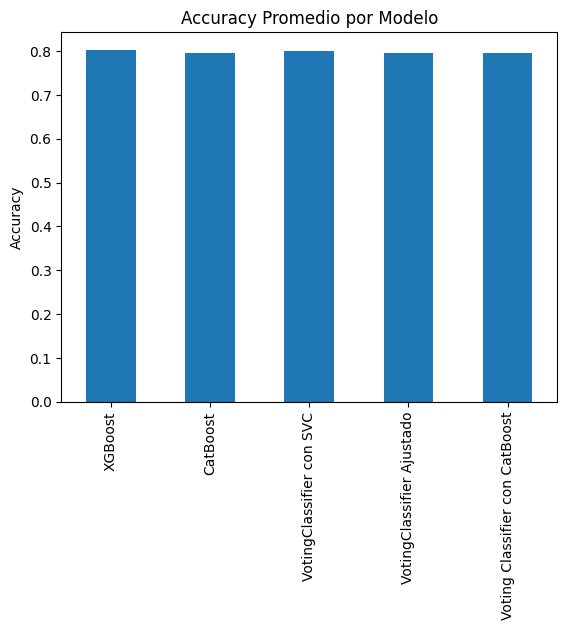

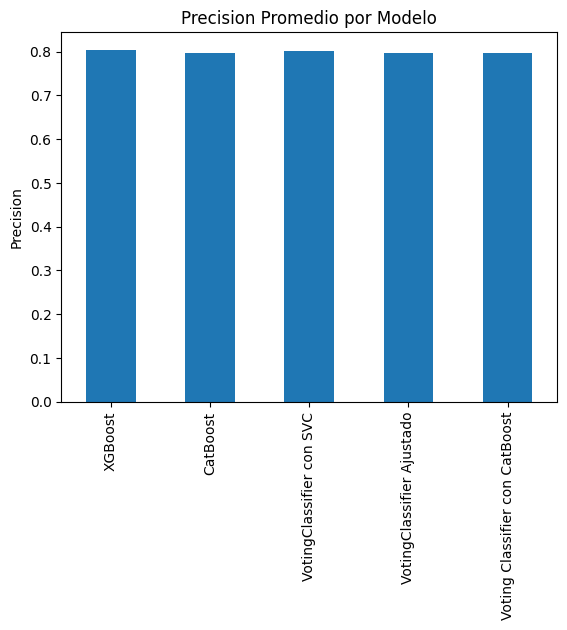

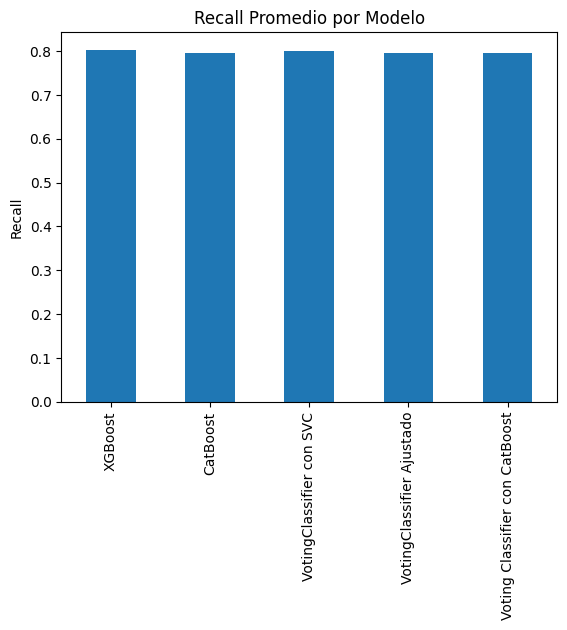

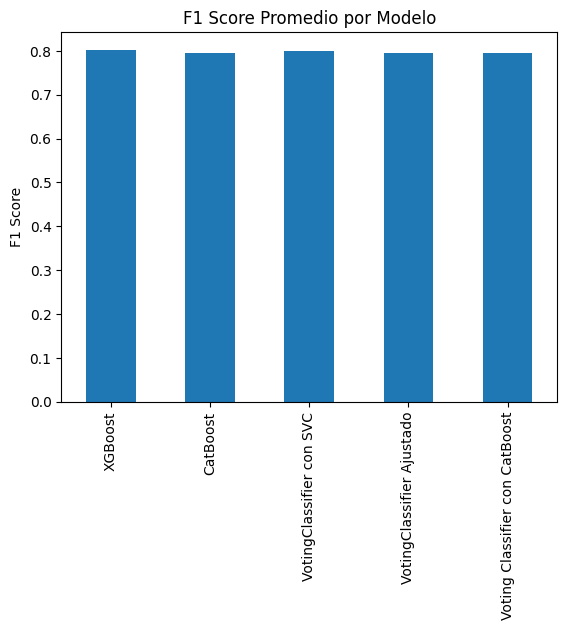

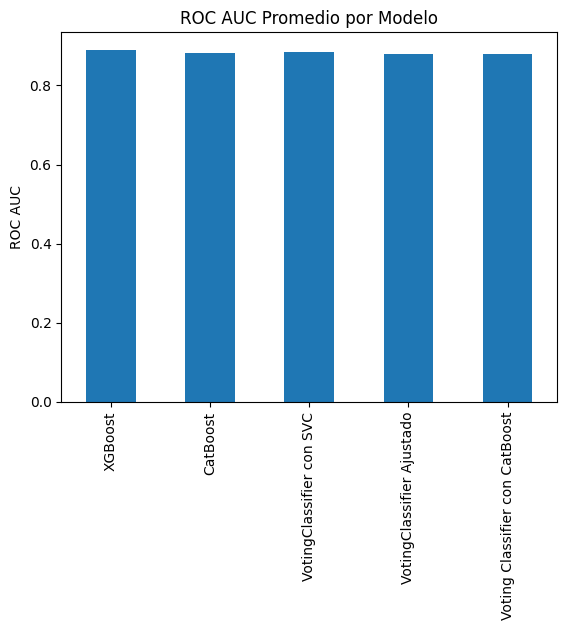

In [7]:
# Calcular los promedios de cada métrica
accuracy_mean = accuracy_df.mean()
precision_mean = precision_df.mean()
recall_mean = recall_df.mean()
f1_mean = f1_df.mean()
roc_auc_mean = roc_auc_df.mean()

# Visualizar los resultados
accuracy_mean.plot(kind='bar', title='Accuracy Promedio por Modelo')
plt.ylabel('Accuracy')
plt.show()

precision_mean.plot(kind='bar', title='Precision Promedio por Modelo')
plt.ylabel('Precision')
plt.show()

recall_mean.plot(kind='bar', title='Recall Promedio por Modelo')
plt.ylabel('Recall')
plt.show()

f1_mean.plot(kind='bar', title='F1 Score Promedio por Modelo')
plt.ylabel('F1 Score')
plt.show()

roc_auc_mean.plot(kind='bar', title='ROC AUC Promedio por Modelo')
plt.ylabel('ROC AUC')
plt.show()


### Diferencias Criticas

XGBoost                           4.4
CatBoost                          2.5
VotingClassifier con SVC          3.4
VotingClassifier Ajustado         2.6
Voting Classifier con CatBoost    2.1
dtype: float64


c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

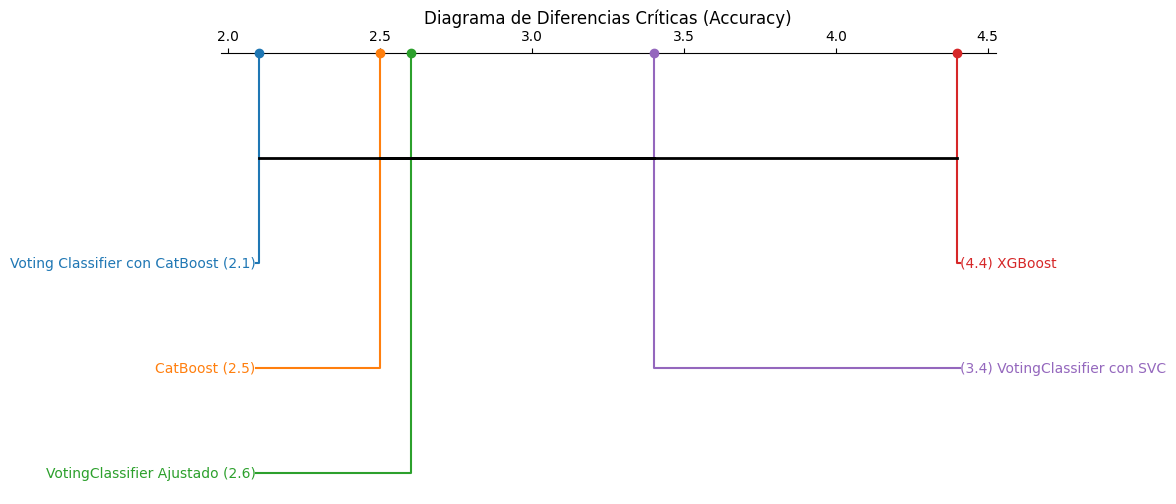

XGBoost                           4.4
CatBoost                          2.4
VotingClassifier con SVC          3.4
VotingClassifier Ajustado         2.8
Voting Classifier con CatBoost    2.0
dtype: float64


c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

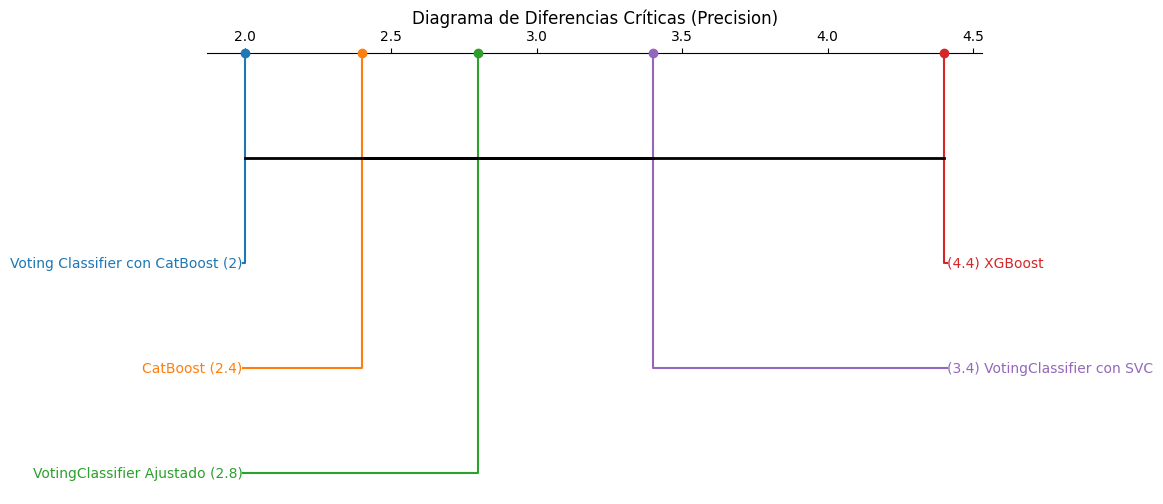

XGBoost                           4.4
CatBoost                          2.5
VotingClassifier con SVC          3.4
VotingClassifier Ajustado         2.6
Voting Classifier con CatBoost    2.1
dtype: float64


c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

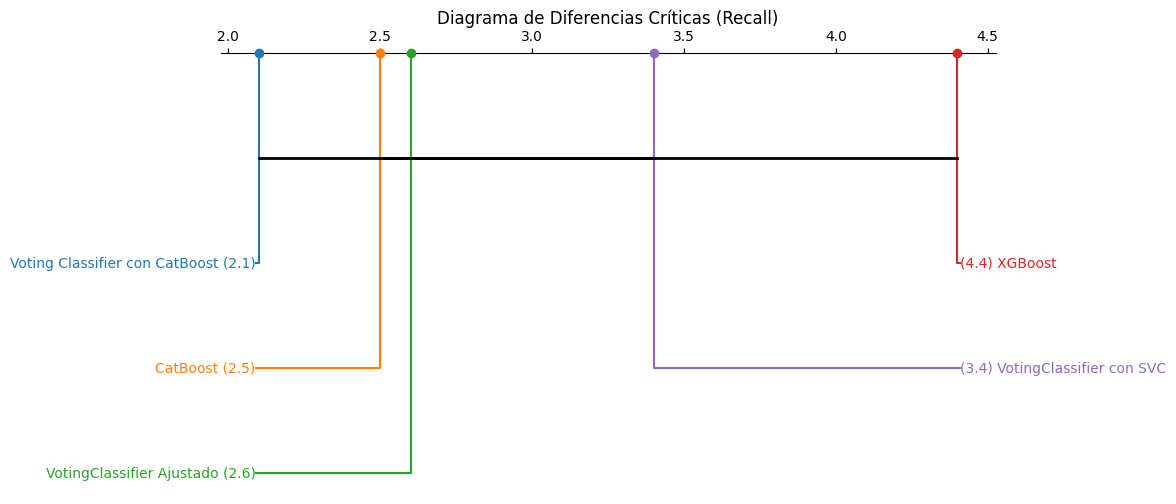

XGBoost                           4.4
CatBoost                          2.6
VotingClassifier con SVC          3.4
VotingClassifier Ajustado         2.6
Voting Classifier con CatBoost    2.0
dtype: float64


c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

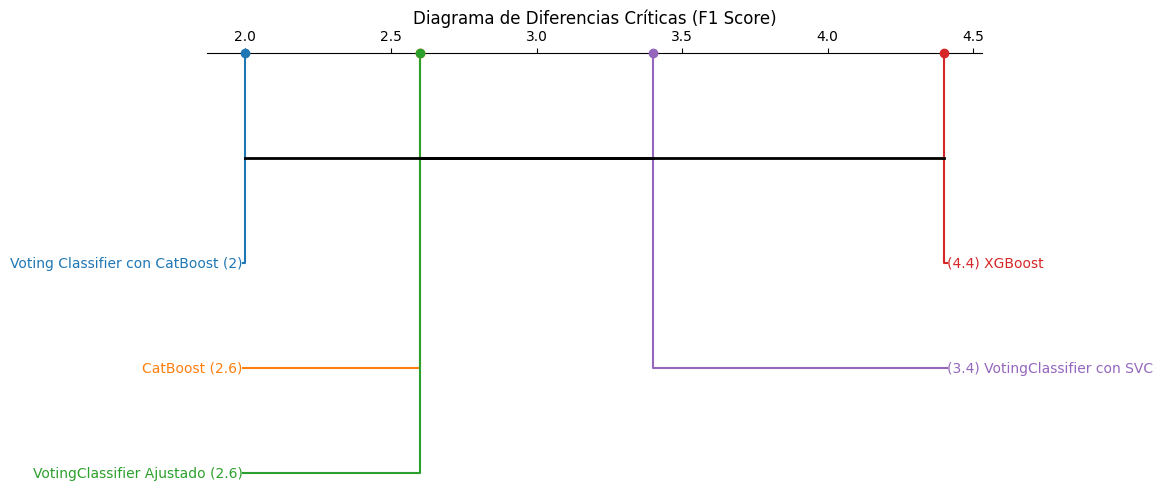

XGBoost                           5.0
CatBoost                          2.4
VotingClassifier con SVC          3.4
VotingClassifier Ajustado         2.6
Voting Classifier con CatBoost    1.6
dtype: float64


c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
c:\Users\Manuel Montufar\Documents\ProyectosManu\Escuela\Concentración\Reto\.venv\Lib\site-packages\scikit_posthocs\_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

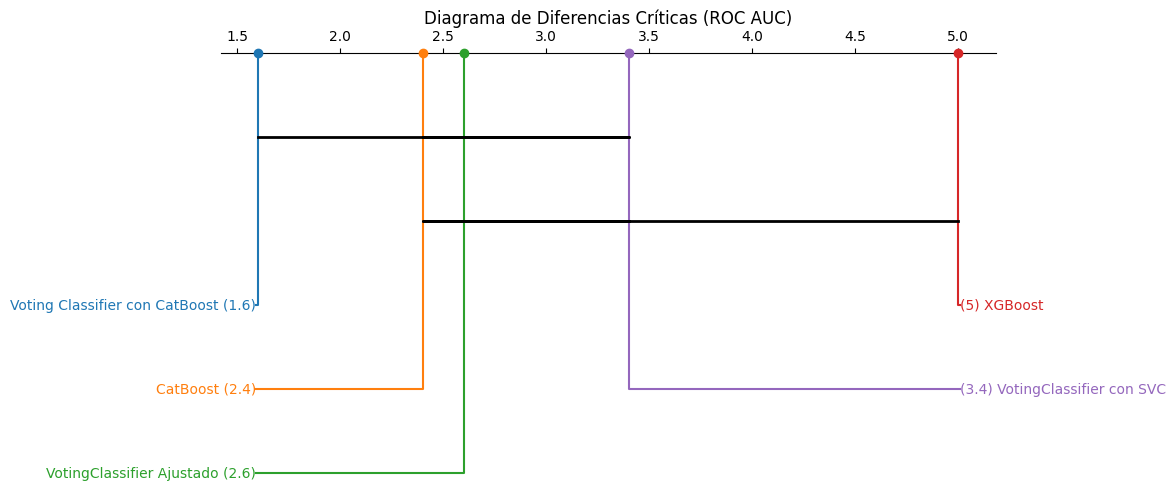

In [8]:
# Function to calculate and visualize critical differences using scikit-posthocs
def calcular_diferencias_criticas(df, metric_name):
    try:
        # Calcular los rangos promedio de los modelos
        avg_rank = df.rank(axis=1).mean(axis=0)
        print(avg_rank)

        # Realizar la prueba post-hoc de Nemenyi
        cd_result = sp.posthoc_nemenyi_friedman(df.values)

        # Graficar el diagrama de diferencias críticas
        plt.figure(figsize=(10, 6), dpi=100)
        plt.title(f'Diagrama de Diferencias Críticas ({metric_name})')
        sp.critical_difference_diagram(avg_rank, cd_result)
        plt.show()

    except ValueError as e:
        print(f"Error al calcular diferencias críticas para {metric_name}: {e}")

# Calcular y graficar diferencias críticas para cada métrica
calcular_diferencias_criticas(accuracy_df, 'Accuracy')
calcular_diferencias_criticas(precision_df, 'Precision')
calcular_diferencias_criticas(recall_df, 'Recall')
calcular_diferencias_criticas(f1_df, 'F1 Score')
calcular_diferencias_criticas(roc_auc_df, 'ROC AUC')


### Curvas ROC AUC

0:	learn: 0.6504834	total: 2.3ms	remaining: 3.45s
1:	learn: 0.6217005	total: 4.82ms	remaining: 3.61s
2:	learn: 0.5962391	total: 7.98ms	remaining: 3.98s
3:	learn: 0.5780788	total: 11.1ms	remaining: 4.13s
4:	learn: 0.5607788	total: 13.7ms	remaining: 4.09s
5:	learn: 0.5463844	total: 16.1ms	remaining: 4s
6:	learn: 0.5329680	total: 17.9ms	remaining: 3.82s
7:	learn: 0.5236396	total: 19.9ms	remaining: 3.72s
8:	learn: 0.5127528	total: 22.3ms	remaining: 3.69s
9:	learn: 0.5041059	total: 24.5ms	remaining: 3.65s
10:	learn: 0.4945167	total: 26.9ms	remaining: 3.65s
11:	learn: 0.4874998	total: 29.2ms	remaining: 3.62s
12:	learn: 0.4821103	total: 32.2ms	remaining: 3.68s
13:	learn: 0.4770767	total: 34.5ms	remaining: 3.67s
14:	learn: 0.4715101	total: 37.7ms	remaining: 3.73s
15:	learn: 0.4675950	total: 40.6ms	remaining: 3.77s
16:	learn: 0.4649757	total: 43.4ms	remaining: 3.78s
17:	learn: 0.4614204	total: 49.3ms	remaining: 4.06s
18:	learn: 0.4574300	total: 54.3ms	remaining: 4.24s
19:	learn: 0.4550253	total

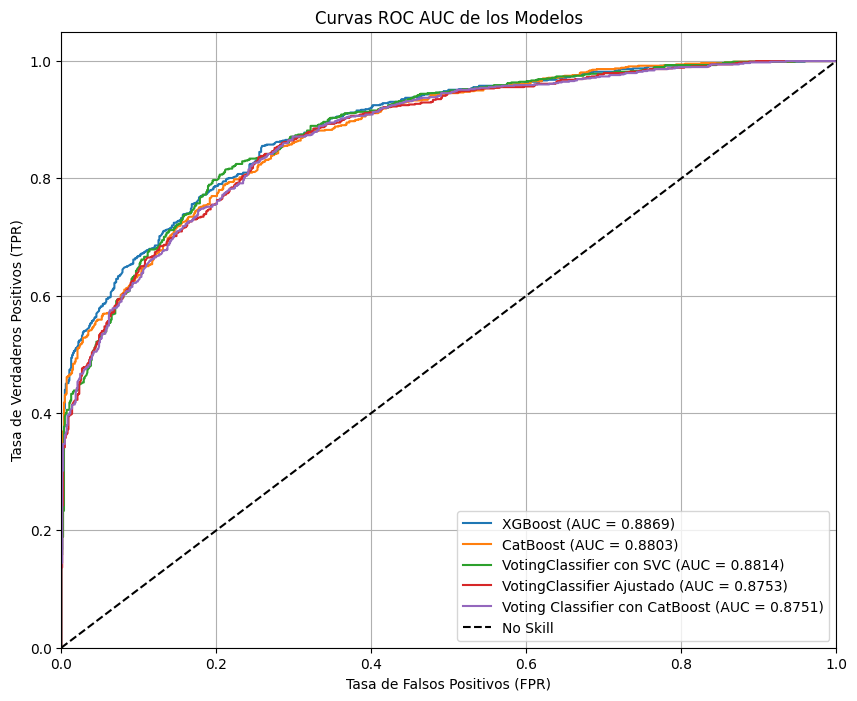

In [13]:
# Diccionario final con todos los clasificadores
classifiers = {
    'XGBoost': xgb,
    'CatBoost': cat_boost,
    'VotingClassifier con SVC': voting_clf_svc,
    'VotingClassifier Ajustado': voting_good,
    'Voting Classifier con CatBoost': voting_cat
}

# Graficar las curvas ROC AUC
plt.figure(figsize=(10, 8))

for model_name, model in classifiers.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir las probabilidades en el conjunto de prueba
    y_prob = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    
    # Calcular las curvas ROC y AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

# Ajustar los ejes y etiquetas
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC AUC de los Modelos')
plt.legend(loc='lower right')
plt.grid()
plt.show()